In [4]:
import numpy as np

In [5]:
pi = RR.pi()

def integrate_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    theta, x, y = var('θ, x, y')
    DE0 = kappa
    DE1 = cos(theta)
    DE2 = sin(theta)
    ICs = [srange[0], theta_0, x_0, y_0]

    P = desolve_system_rk4([DE0, DE1, DE2], [theta, x, y], ics=ICs, ivar=s, end_points=srange[1], step=step)
    return P


def splines_from_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    P = integrate_curvature(kappa, s, srange, theta_0, x_0, y_0, step)

    x_spline = spline([(s, x) for s, theta, x, y in P])
    y_spline = spline([(s, y) for s, theta, x, y in P])

    return (x_spline, y_spline)


def spline_avg(f):
    a = f.list()[0][0]
    b = f.list()[-1][0]
    return f.definite_integral(a, b) / (b - a)


def splines_to_angular_momentum(x_0, y_0, x_1, y_1, dt, srange=(0,1), center=(0,0)):
    def theta(a, b): return arccos(a.inner_product(b) / (a.norm() * b.norm()))
    def v_x(z): return (x_0(z) - x_1(z)) / dt
    def v_y(z): return (y_0(z) - y_1(z)) / dt
    def v(z): return vector([v_x(z), v_y(z)])
    def r(z): return sqrt((x_0(z) - center[0])^2 + (y_0(z) - center[1])^2)
    def w(z): return v(z).norm() * sin(theta(v(z), vector([x_0(z) - center[0], y_0(z) - center[1]]))) # |v| * sin(theta)
    integrand = lambda z: w(z) * r(z) # w * r
    angular_momentum = numerical_integral(integrand, srange[0], srange[1])[0] # int_S w * r^2 ds
    return angular_momentum


def splines_to_moment(x, y, srange=(0,1), center=(0,0)):
    return numerical_integral(lambda z: ((x(z) - center[0])^2 + (y(z) - center[1])^2), srange[0], srange[1])[0]


def translate_spline(f, dy):
    return spline([(x, y + dy) for x, y in f.list()])


def rotate_splines(x, y, theta):
    x_list = x.list()
    y_list = y.list()
    
    R = matrix([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    
    completed_x_list = [(s, x, y(s)) for s, x in x_list]
    completed_y_list = [(s, x(s), y) for s, y in y_list]
    
    rotated_x_spline = spline([(s, (R*vector([x, y]))[0]) for s, x, y in completed_x_list])
    rotated_y_spline = spline([(s, (R*vector([x, y]))[1]) for s, x, y in completed_y_list])
    
    return (rotated_x_spline, rotated_y_spline)


def splines_fix_center(x, y, center=(0,0)):
    x_bar = spline_avg(x)
    y_bar = spline_avg(y)
    return (translate_spline(x, -x_bar + center[0]), translate_spline(y, -y_bar + center[1]))

def splines_from_curvature_fix_center(kappa, s, srange=(0,1), theta_0=0, center=(0,0), step=0.1):
    x, y = splines_from_curvature(kappa, s, srange, theta_0, 0, 0, step)
    return splines_fix_center(x, y, center)


def flow_curvature(kappa, srange, arange, acount, theta_0=0, center=(0,0), step=0.1):
    splines = []
    rotated_splines = []
    space, dt = np.linspace(arange[0], arange[1], acount, retstep=True)
    total_counterrotation = 0
    curves = []
    for a in space:
        print(f"Calculating curve for a = {a}...")
        x, y = splines_from_curvature_fix_center(kappa(s, a), s, srange=srange, theta_0=theta_0, center=center, step=step)
        # print(x.list())
        # print(y.list())
        print("Done with curvature integration.")

        if len(splines) >= 1:
            print("Calculating angular momentum...")
            angular_momentum = splines_to_angular_momentum(splines[-1][0], splines[-1][1], x, y, dt, srange=srange, center=center)
            print("Done with angular momentum.")
            print("Calculating moment...")
            I = splines_to_moment(x, y, srange=srange, center=center)
            print("Done with moment.")
            print(f"I = {I}")
            angular_velocity = angular_momentum / I
            dtheta = angular_velocity * dt
            total_counterrotation += dtheta
            print(f"dtheta: {dtheta}\n")
            
        rotated_x, rotated_y = rotate_splines(x, y, total_counterrotation)
        rotated_translated_x, rotated_translated_y = splines_fix_center(rotated_x, rotated_y, center)
        rotated_splines.append((rotated_translated_x, rotated_translated_y))
        splines.append((x, y))
        
    return splines, rotated_splines

In [6]:
def metric_surf_rev_numerical(phi, psi):
    def g(u, v):
        X_u = vector([-phi(v)*sin(u), phi(v)*cos(u), 0])
        X_v = vector([phi.derivative(v)*cos(u), phi.derivative(v)*sin(u), psi.derivative(v)])
        E = X_u.dot_product(X_u)
        G = X_v.dot_product(X_v)
        return matrix([[E, 0], [0, G]])
    return g


def sample_metric_eigenvals(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    def angle(a, b):
        return arccos(a.inner_product(b) / (a.norm() * b.norm())) if a.norm() * b.norm() != 0 else 0
    
    squares = []
    transformed_squares = []
    ellipses = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        g_curr = g(u, v)
        eigenvectors = g_curr.eigenvectors_right()
        eigvec = eigenvectors[0][1][0]
        k1 = eigenvectors[0][0]
        if eigenvectors[0][2] == 2:
            k2 = k1
        else:
            k2 = eigenvectors[1][0]
        
        square = matrix([[0, -sq_len/2, 0, sq_len/2], [-sq_len/2, 0, sq_len/2, 0]])
        cross = vector([eigvec[0], eigvec[1], 0]).cross_product(vector([1, 0, 0]))
        theta = arctan2(cross[2], eigvec.dot_product(vector([1, 0])))
        R = matrix([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
        
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g_curr * R * square
        
        squares.append((R * square) + translate)
        transformed_squares.append(transformed + translate)
        ellipses.append((u, v, k1*sq_len/2, k2*sq_len/2, -theta))

    return squares, transformed_squares, ellipses

In [7]:
def reparametrize_by_arclength(x, y, *splines, t0=None, tf=None, dt=0.001, ds=0.1):
    if t0 is None:
        t0 = x.list()[0][0]
    if tf is None:
        tf = x.list()[-1][0]
        
    t_prev = t0 
    t = dt
    
    step_dist = 0
    total_dist = 0
    
    x_list = [(t0, x(t0))]
    y_list = [(t0, y(t0))]
    splines_lists = []
    for i in range(len(splines)):
        splines_list.append([])
    
    def reparametrize_step():
        x_list.append((total_dist, x(t)))
        y_list.append((total_dist, y(t)))
        for i, spline_list in enumerate(splines_lists):
            spline_list.append((total_dist, splines[i](t)))
    
    while t <= tf:
        x_diff = x(t) - x(t_prev)
        y_diff = y(t) - y(t_prev)
        
        dist = sqrt(x_diff**2 + y_diff**2)
        step_dist += dist
        total_dist += dist
        
        if step_dist >= ds:
            reparametrize_step()
            step_dist = 0
        
        t_prev = t
        t += dt
    
    if total_dist > x.list()[-1][0]:
        t = t_prev
        reparametrize_step()
    
    new_x_spline = spline(x_list)
    new_y_spline = spline(y_list)
    new_splines = map(lambda spline_list: spline(spline_list), splines_lists)
    
    if len(splines_lists) > 0:
        return new_x_spline, new_y_spline, new_splines
    else:
        return new_x_spline, new_y_spline

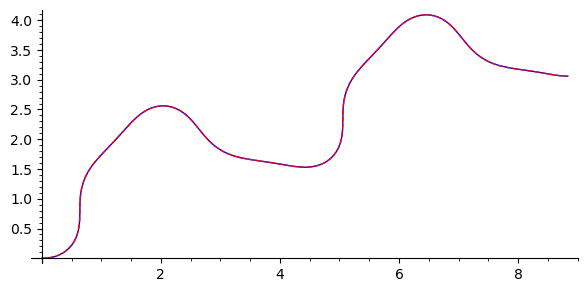

In [8]:
# x = spline([(0, 1), (1, 2), (4, 5), (5, 3)])
# y = spline([(0, 2), (1, 4), (4, 5), (5, 3)])
srange=(0, 4*RR.pi())
kappa(s) = sin(3*s)+cos(s)
x, y = splines_from_curvature(kappa, s, srange, step=0.01)
xs, ys = reparametrize_by_arclength(x, y, ds=0.02)
plot1 = parametric_plot((x, y), srange, color='blue')
plot2 = parametric_plot((xs, ys), (xs.list()[0][0], xs.list()[-1][0]), color='red', linestyle='--')
show(plot1 + plot2)

In [9]:
def xy_splines_from_hm(h, m, srange=(0, pi), step_size=0.1, eps=0.01):
    def y(rho):
        if m(rho) < 0:
            print(f"negative: {rho}, {m(rho)}")
            return 0
        return sqrt(m(rho))
    
    rho_space = np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))
    y_spline = spline([(rho, y(rho)) for rho in rho_space])
    
    def x(rho):
        def integrand(s):
            d = h(s) - (y_spline.derivative(s))**2
            return sqrt(d) if d >= 0 else 0
        return numerical_integral(integrand, eps, rho)[0]
    
    x_spline = spline([(rho, x(rho)) for rho in rho_space])
    
    return x_spline, y_spline

In [19]:
def sqrt_spline(f):
    return spline([(x, sqrt(y)) for x, y in f])

def to_spline(f, srange=(0, pi), step_size=0.01):
    return spline([(s, f(s)) for s in np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))])

negative: 3.141592653589793, -1.2370527372988638e-20


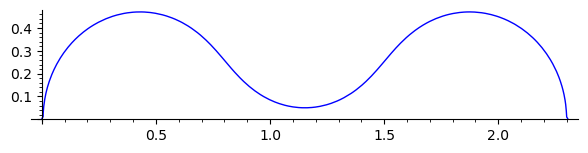

In [11]:
# c3 = 0.021
# c5 = 0.598
c3 = 0.766
c5 = -0.091
h(rho) = 1
m(rho) = 0.0000 + ((sin(rho) + c3*sin(3*rho) + c5*sin(5*rho))/(1 + 3*c3 + 5*c5))**2

eps = 0.1

srange=(0, pi)
h = to_spline(h, srange)
m = to_spline(m, srange)


x, y = xy_splines_from_hm(h, m, srange, step_size=0.001, eps=0)

parametric_plot((x, y), (x.list()[0][0], x.list()[-1][0]))

In [13]:
def hm_to_ricci_tensor(h, m, return_K=False, eps=0.1):
    sqrt_m = sqrt_spline(m)
    
    def K(rho):
        return -sqrt_m.derivative(rho, order=2) / sqrt_m(rho)
    
    def R(rho):
        if rho <= eps or rho >= pi - eps:
            rho = eps
        R11 = K(rho) + ((m.derivative(rho) * h.derivative(rho)) / (4 * m(rho) * h(rho)))
        R22 = (R11 / h(rho)) * m(rho)
        return matrix([[R11, 0], [0, R22]])
    return R if not return_K else (R, K)

In [14]:
R, K = hm_to_ricci_tensor(h, m, return_K=True)

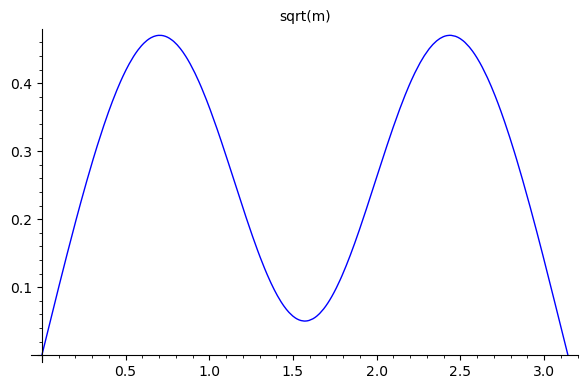

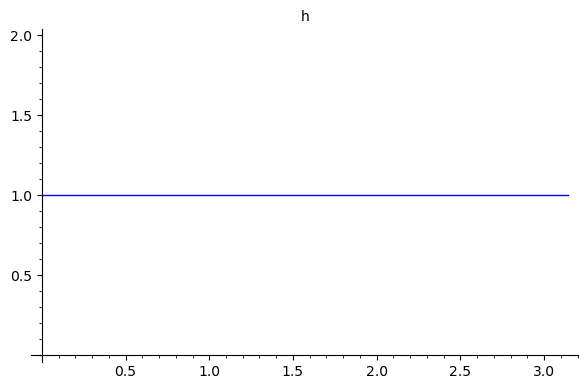

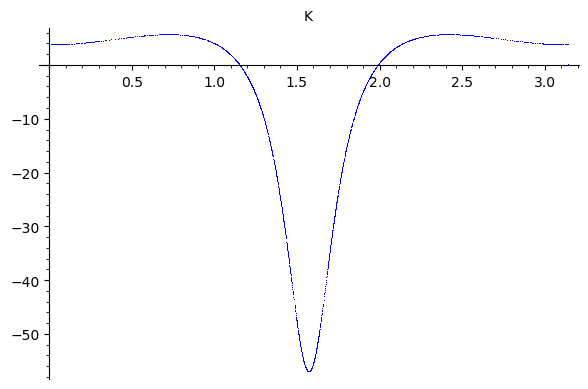

In [15]:
# show(plot(m, srange))
show(plot(lambda z: sqrt(m(z)), srange, title="sqrt(m)"))
show(plot(h, srange, title="h"))
show(plot(K, srange, marker=",", linestyle="", title="K"))

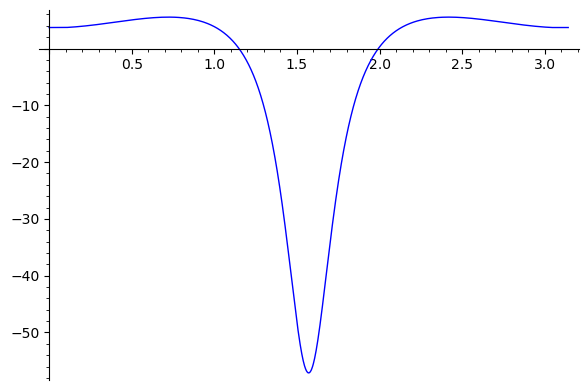

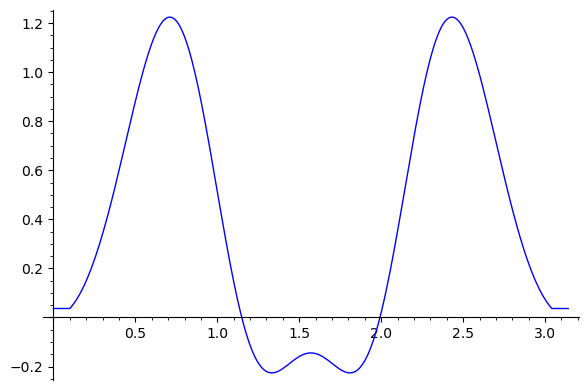

In [16]:
def R11(rho): return R(rho)[0][0]
def R22(rho): return R(rho)[1][1]
show(plot(R11, srange))
show(plot(R22, srange))

1.001e-05
i: 0
i: 1
negative: 3.141592653589793, -3.5461944833521145e-19
i: 2
negative: 3.141592653589793, -9.593691542536913e-19
i: 3
i: 4
negative: 3.141592653589793, -2.0550206014939538e-18
i: 5
i: 6
i: 7
negative: 3.141592653589793, -1.6647847652985967e-18
i: 8
i: 9
i: 10
i: 11
negative: 3.141592653589793, -1.2108951569309699e-18
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
negative: 3.141592653589793, -9.849432570683471e-20
i: 18
i: 19
negative: 3.141592653589793, -1.8362922451587663e-18
i: 20
i: 21
negative: 3.141592653589793, -2.386673969538962e-18
i: 22
negative: 3.141592653589793, -2.833892728413741e-19
i: 23
i: 24
i: 25
negative: 3.141592653589793, -3.825886915660239e-19
i: 26
i: 27
negative: 3.141592653589793, -2.6778474692264687e-18
i: 28
negative: 3.141592653589793, -1.828269162225898e-18
i: 29
i: 30
i: 31
i: 32
negative: 3.141592653589793, -8.945378689386932e-19
i: 33
i: 34
i: 35
negative: 3.141592653589793, -9.367472502948224e-19
i: 36
i: 37
i: 38
negative: 3.141592653589793, -6.

i: 256
negative: 3.141592653589793, -1.2180097872975349e-18
i: 257
i: 258
negative: 3.141592653589793, -1.609607643113136e-18
i: 259
negative: 3.141592653589793, -6.313183626999074e-19
i: 260
negative: 3.141592653589793, -1.4621911468069879e-19
i: 261
negative: 3.141592653589793, -3.024348589027044e-19
i: 262
negative: 3.141592653589793, -1.9785328020661337e-18
i: 263
i: 264
negative: 3.141592653589793, -1.8889112676821603e-18
i: 265
negative: 3.141592653589793, -5.596099243734699e-19
i: 266
i: 267
i: 268
i: 269
negative: 3.141592653589793, -4.690500635540086e-19
i: 270
negative: 3.141592653589793, -3.8268908225607452e-19
i: 271
i: 272
negative: 3.141592653589793, -1.5216698677098437e-18
i: 273
negative: 3.141592653589793, -1.5034983687775672e-18
i: 274
negative: 3.141592653589793, -1.6762996361418619e-18
i: 275
negative: 3.141592653589793, -5.0724493140118365e-19
i: 276
negative: 3.141592653589793, -2.0202571326362247e-18
i: 277
i: 278
i: 279
negative: 3.141592653589793, -2.5864287146

i: 488
i: 489
negative: 3.141592653589793, -2.103752928484532e-19
i: 490
i: 491
i: 492
negative: 3.141592653589793, -1.1329074155519961e-19
i: 493
negative: 3.141592653589793, -4.623862352708091e-19
i: 494
i: 495
negative: 3.141592653589793, -1.1013444203452164e-18
i: 496
negative: 3.141592653589793, -9.669045008767071e-19
i: 497
i: 498
negative: 3.141592653589793, -7.873909208007863e-19
i: 499
negative: 3.141592653589793, -1.9778995028019187e-19
i: 500
negative: 3.141592653589793, -2.1776594281843813e-18
i: 501
i: 502
negative: 3.141592653589793, -2.1926626474232316e-18
i: 503
negative: 3.141592653589793, -3.2845204060949205e-18
i: 504
negative: 3.141592653589793, -1.7103488757627999e-18
i: 505
negative: 3.141592653589793, -2.924351070209564e-18
i: 506
negative: 3.141592653589793, -1.5612845475748455e-18
i: 507
negative: 3.141592653589793, -5.184196461000942e-19
i: 508
i: 509
negative: 3.141592653589793, -1.65852905996786e-19
i: 510
negative: 3.141592653589793, -1.0974465998844751e-18

negative: 3.141592653589793, -2.03718507414291e-18
i: 713
i: 714
negative: 3.141592653589793, -3.0540246069806326e-19
i: 715
negative: 3.141592653589793, -1.832243321572157e-18
i: 716
negative: 3.141592653589793, -3.1065202890774137e-18
i: 717
negative: 3.141592653589793, -1.359845688782685e-18
i: 718
i: 719
negative: 3.141592653589793, -2.713770247365121e-19
i: 720
i: 721
i: 722
i: 723
negative: 3.141592653589793, -3.5936541230914526e-19
i: 724
i: 725
negative: 3.141592653589793, -7.744061883261703e-19
i: 726
negative: 3.141592653589793, -2.2330286473379975e-18
i: 727
i: 728
negative: 3.141592653589793, -5.042893224777026e-19
i: 729
negative: 3.141592653589793, -1.2553577945167248e-19
i: 730
negative: 3.141592653589793, -1.784501789316706e-18
i: 731
i: 732
i: 733
negative: 3.141592653589793, -1.3106453388716055e-18
i: 734
negative: 3.141592653589793, -1.3076484313811091e-18
i: 735
negative: 3.141592653589793, -6.385571658753356e-19
i: 736
i: 737
i: 738
i: 739
i: 740
i: 741
negative: 3

negative: 3.141592653589793, -1.3654314069572949e-18
i: 977
i: 978
negative: 3.141592653589793, -1.0483888200704037e-18
i: 979
negative: 3.141592653589793, -1.8122154720578114e-18
i: 980
negative: 3.141592653589793, -1.2741556829556486e-18
i: 981
negative: 3.141592653589793, -2.4977828591802978e-20
i: 982
i: 983
i: 984
negative: 3.141592653589793, -6.376239651023568e-19
i: 985
i: 986
negative: 3.141592653589793, -1.6493002814604952e-18
i: 987
negative: 3.141592653589793, -7.121422947510014e-19
i: 988
negative: 3.141592653589793, -2.0815632811021535e-19
i: 989
negative: 3.141592653589793, -2.7738978681187313e-18
i: 990
negative: 3.141592653589793, -1.8737446255775104e-18
i: 991
i: 992
negative: 3.141592653589793, -1.8540097780039294e-18
i: 993
i: 994
negative: 3.141592653589793, -1.1472107967611755e-18
i: 995
negative: 3.141592653589793, -1.1718250989867536e-18
i: 996
i: 997
i: 998
negative: 3.141592653589793, -2.5247807988610156e-18
i: 999
i: 1000
negative: 3.141592653589793, -4.901149

Animation with 11 frames
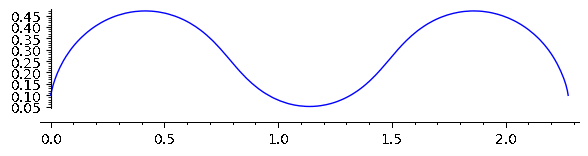

In [18]:
dt = 0.00001
N = 1001
space, dt = np.linspace(0, dt*N, N, retstep=True)
print(dt)

h_ = h
m_ = m

plots = []

for i in range(N):
    R = hm_to_ricci_tensor(h_, m_)
    def R11(rho): return R(rho)[0][0]
    def R22(rho): return R(rho)[1][1]

#     for z in np.linspace(eps, pi-eps):
#         print(f"rho: {z}, R11: {R11(z)}, R22: {R22(z)}")
    print(f"i: {i}")
    
    h_ = spline([(rho, h_rho_ - 2*R11(rho)*dt) for rho, h_rho_ in filter(lambda z: z[0] >= eps and z[0] <= pi-eps, h_.list())])
    m_ = spline([(rho, m_rho_ - 2*R22(rho)*dt) for rho, m_rho_ in filter(lambda z: z[0] >= eps and z[0] <= pi-eps, m_.list())])
#     print(m_.list())

    m_.append((0, 0))
    m_.append((pi, 0))
    
    sqrt_m = sqrt_spline(m_)
    
    h_.append((0, sqrt_m.derivative(0)))
    h_.append((pi, sqrt_m.derivative(pi)))
    

    x, y = xy_splines_from_hm(h_, m_, srange, eps=eps)
    
    
    if i % 100 == 0:
        plots.append(parametric_plot((x, y), (eps, pi-eps)))
    
animate(plots)